# PicnicHealth take-home analysis project

## How does weather change riding habits in San Francisco?

#### By: Arjun Shankar

This notebook presents a preliminary analysis of San Fransisco Bike Share data (https://www.fordgobike.com/system-data) and San Fransisco weather data (https://drive.google.com/file/d/1Pbm49OYLVUwelYgfC_czfYUavYr6U3oF/edit) pulled from  https://www.ncdc.noaa.gov/data-access/land-based-station-data. The goal is to determine how weather changes riding habits in San Fransisco.

## 1. Import and View data

In [1]:
import csv
import datetime as dt
import numpy as np
import pandas as pd
import os
import statistics
import matplotlib.pyplot as plt

import earthpy as et

import folium
from folium import plugins

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

Import bike csv data

In [2]:
bike_csv=[file for file in os.listdir() if file.endswith('tripdata.csv')]

In [3]:
bike_df=pd.DataFrame()
for item in bike_csv:
    df=pd.read_csv(item)
    bike_df=pd.concat([bike_df,df],sort=True)

List Bike Variables

In [4]:
bike_df.dtypes

bike_id                      int64
bike_share_for_all_trip     object
duration_sec                 int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name            object
end_time                    object
member_birth_year          float64
member_gender               object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name          object
start_time                  object
user_type                   object
dtype: object

In [31]:
bike_df.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,start_date
0,1035,No,598,114.0,37.764478,-122.402570,Rhode Island St at 17th St,2018-03-01 00:09:45.187,1988.0,Male,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2018-02-28 23:59:47.097,Subscriber,2018-02-28
1,1673,No,943,324.0,37.788300,-122.408531,Union Square (Powell St at Post St),2018-02-28 23:36:59.974,1987.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-02-28 23:21:16.495,Customer,2018-02-28
2,3498,No,18587,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:42.925,1986.0,Female,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:55.190,Customer,2018-02-28
3,3129,No,18558,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:12.450,1981.0,Male,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:53.621,Customer,2018-02-28
4,1839,Yes,885,297.0,37.322980,-121.887931,Locust St at Grant St,2018-02-28 23:29:58.608,1976.0,Female,308.0,37.336802,-121.894090,San Pedro Square,2018-02-28 23:15:12.858,Subscriber,2018-02-28


View Bike Stations on Map

In [6]:
stations=bike_df.groupby('start_station_id')['start_station_latitude','start_station_longitude'].mean()

In [7]:
print('There are ', len(bike_df.start_station_latitude.unique()), 'bike stations in San Fransisco')
m = folium.Map(
    location=[37.8174, -122.37],
    zoom_start=12,
    #tiles='Stamen Terrain'
)

tooltip = 'Click for Station ID'
for index in stations.index:
    folium.Marker([stations.start_station_latitude[index], stations.start_station_longitude[index]], popup='Station ID: '+str(index), tooltip=tooltip).add_to(m)

m


There are  419 bike stations in San Fransisco


Import Weather CSV

In [8]:
weather_df=pd.read_csv('NOAA_SF_weather.csv')

List Weather Variables

In [9]:
weather_df.dtypes

DATE                               object
HOURLYPrecip                      float64
HOURLYAltimeterSetting            float64
DAILYMaximumDryBulbTemp           float64
DAILYMinimumDryBulbTemp           float64
DAILYAverageDryBulbTemp           float64
DAILYDeptFromNormalAverageTemp    float64
DAILYHeatingDegreeDays            float64
DAILYCoolingDegreeDays            float64
DAILYSunrise                        int64
DAILYSunset                         int64
DAILYPrecip                       float64
dtype: object

In [10]:
weather_df.head()

,DATE,HOURLYPrecip,HOURLYAltimeterSetting,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYSunrise,DAILYSunset,DAILYPrecip
0,2017-01-01 19:59,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
1,2017-01-01 23:59,NaN,NaN,52.0,45.0,48.0,-2.6,17.0,0.0,725,1703,0.05
2,2017-01-02 00:59,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
3,2017-01-02 03:59,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
4,2017-01-02 04:59,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN


## 2. Data Cleaning

After examining the weather_df, it is clear that there are no entries for HOURLYAltimeterSetting. Furthermore, the DAILY average weather metrics are collected separately from HourlyPRECIP metrics. To simplify analysis, I will focus on the Daily Metrics first.

Create a Daily Weather DataFrame with only the Daily Average Weather Metrics

In [11]:
daily_weather_df=weather_df.dropna(axis=0, how='all', thresh=None, subset=['DAILYMaximumDryBulbTemp'], inplace=False)

In [12]:
daily_weather_df.drop(labels=['HOURLYPrecip','HOURLYAltimeterSetting'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Change Strings to datetime objects

In [13]:
daily_weather_df.DATE=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M').date() for date in daily_weather_df.DATE]

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [14]:
bike_df['start_date']=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f').date() for date in bike_df.start_time]
bike_df.start_time=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f') for date in bike_df.start_time]
bike_df.end_time=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f') for date in bike_df.end_time]


Merge the Daily Weather Data with the Bike Data

In [15]:
daily_bike_df=pd.merge(bike_df, daily_weather_df, left_on='start_date',right_on='DATE',how='inner')

Add a Column with the Day of the Week

In [16]:
daily_bike_df['day_of_week']=[date.isoweekday() for date in daily_bike_df.DATE]

In [17]:
#Save daily_bike_df 
#daily_bike_df.to_pickle('daily_bike_df.pkl')
#daily_bike_df=pd.read_pickle('daily_bike_df.pkl')

## 3. Analysis

### 3.1 Separation of Weekday and Weekend Trends

First, I notice that Weekend Trends differ significantly from Weekday Trends. More rides are taken on Weekdays while Weekend rides are longer duration. I should be careful to use either Weekend or Weekday trends when comparing to weather trends.

In [18]:
# Define Weekday and Weekend Indices
Weekday=(daily_bike_df.groupby('DATE').day_of_week.mean() !=7) &(daily_bike_df.groupby('DATE').day_of_week.mean()!=6)
Weekend=(daily_bike_df.groupby('DATE').day_of_week.mean() ==7) |(daily_bike_df.groupby('DATE').day_of_week.mean()==6)

Text(0.5,0,'Date')

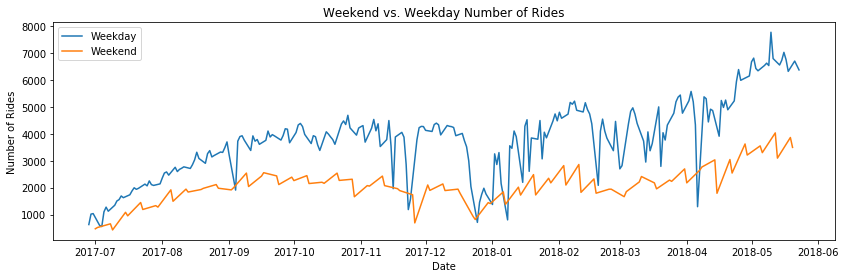

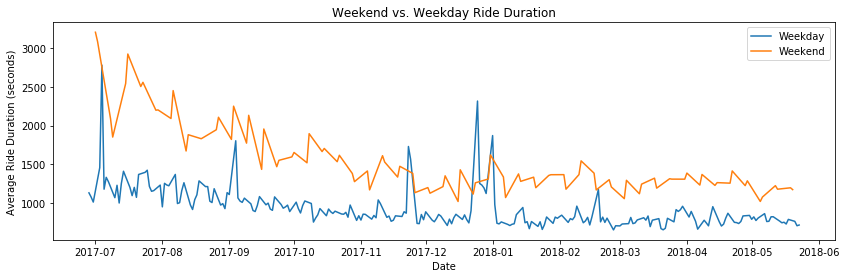

In [19]:
# Plot the Weekend vs. Weekday Number of Rides
f=plt.figure(figsize=(14,4))

daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values].plot()

daily_bike_df.groupby('DATE').duration_sec.count()[Weekend.values].plot()

plt.legend(['Weekday','Weekend'])
plt.title('Weekend vs. Weekday Number of Rides')
plt.ylabel('Number of Rides')
plt.xlabel('Date')

# Plot the Weekend vs. Weekday Ride Duration
f=plt.figure(figsize=(14,4))

daily_bike_df.groupby('DATE').duration_sec.mean()[Weekday.values].plot()

daily_bike_df.groupby('DATE').duration_sec.mean()[Weekend.values].plot()

plt.legend(['Weekday','Weekend'])
plt.title('Weekend vs. Weekday Ride Duration')
plt.ylabel('Average Ride Duration (seconds)')
plt.xlabel('Date')

### 3.2 Data Hypothesis: Higher Precipitation will decrease number of rides on Weekdays as compared to number of rides in consecutive Weekdays

To explore the hypothesis roughly, I plotted the number of rides taken and the daily precipitation with aligned x axis (dates). As the figure below shows, it appears that during rainy days, not as many rides are taken. To determine if there is a relationship, I will calculate the difference between number of rides taken on rainy days versus number of rides taken 5 days before and after the given rainy day. 

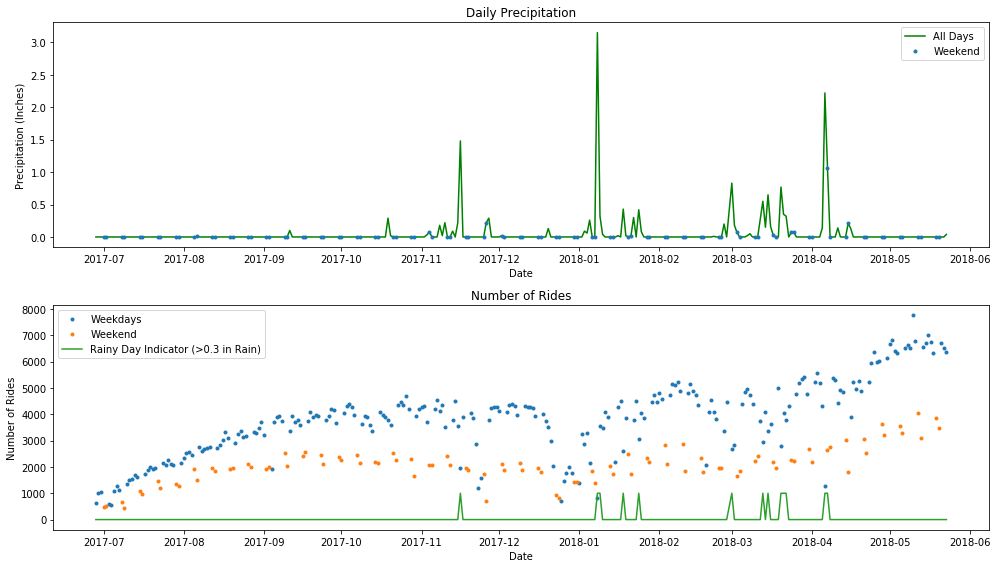

In [21]:
# Store dates in a variable for convenience when plotting
dates=np.array(list(daily_bike_df.groupby('DATE').groups.keys()))

# Plot the Daily Precipitation
f=plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(dates,daily_bike_df.groupby('DATE').DAILYPrecip.mean(),'g')
plt.plot(dates[Weekend.values],daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekend.values],'.')
plt.legend(['All Days','Weekend'])

plt.title('Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')

# Plot the Number of Rides on Weekends Weekdays
plt.subplot(2,1,2)
plt.plot(dates[Weekday.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values],'.')
plt.plot(dates[Weekend.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekend.values],'.')

plt.plot(dates,(daily_bike_df.groupby('DATE').DAILYPrecip.mean()>0.3)*1000)
plt.legend(['Weekdays','Weekend','Rainy Day Indicator (>0.3 in Rain)'])


plt.title('Number of Rides')
plt.xlabel('Date')
plt.ylabel('Number of Rides')

plt.tight_layout()

### Having done some exploratory data analysis, I can now formulate a more specific hypothesis:

Null hypothesis: Precipitation>0.3 Inches will not significantly decrease number of rides on Weekdays as compared to number of rides in 10 consecutive Weekdays.

Alterative hypothesis: Precipitation>0.3 Inches will significantly decrease number of rides on Weekdays as compared to number of rides in 10 consecutive Weekdays. 

Chosen Level of Significance $\alpha$ : 0.05 (95% confidence, Critical z Value =1.96,-1.96)



In [22]:
rainy=(daily_bike_df.groupby('DATE').DAILYPrecip.mean()>0.3)
#daily_bike_df.groupby('DATE').duration_sec.count()[~rainy.values & Weekday.values]

Text(0,0.5,'Daily # Rides - 10 Day Average')

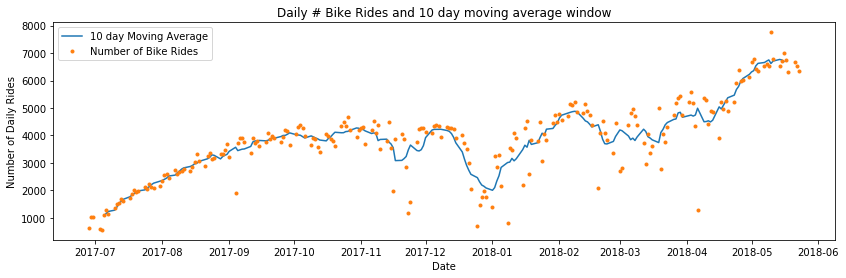

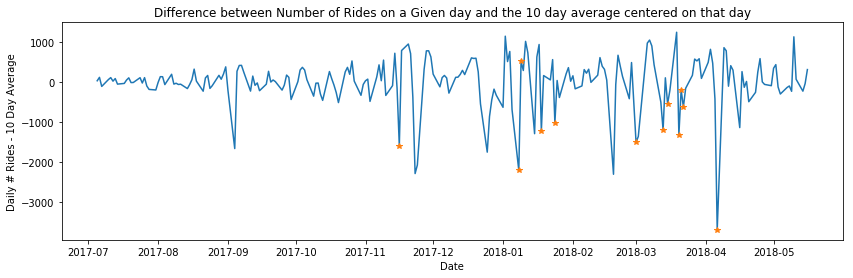

In [23]:
# Define Rainy Day Index
rainy=(daily_bike_df.groupby('DATE').DAILYPrecip.mean()>0.3)

# Create the distribution of all rainy weekday number of rides
y=daily_bike_df.groupby('DATE').duration_sec.count()[rainy.values & Weekday.values]

# Create a Kernel to Average Number of Rides in Windows of 10 days
N=10
kernel=np.ones(N+1)/N
kernel[int(N/2)]=0

x=np.convolve(daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values], kernel, mode='same')


#Plot the Moving Average Window of Ride Numbers
f=plt.figure(figsize=(14,4))

plt.plot(dates[Weekday.values][5:-5],x[5:-5])
plt.plot(dates[Weekday.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values],'.')
plt.title('Daily # Bike Rides and 10 day moving average window')
plt.legend(['10 day Moving Average','Number of Bike Rides'])
plt.xlabel('Date')
plt.ylabel('Number of Daily Rides')

# Plot the Difference between Number of Rides on a Given day and the 10 day average centered on that day.
f=plt.figure(figsize=(14,4))

plt.plot(dates[Weekday.values][5:-5],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values][5:-5]-x[5:-5])

plt.plot(dates[Weekday.values][(daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekday.values]>0.3)],\
         y-x[(daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekday.values]>0.3)],'*')

plt.title('Difference between Number of Rides on a Given day and the 10 day average centered on that day')
plt.xlabel('Date')
plt.ylabel('Daily # Rides - 10 Day Average')


### Precipitation>0.3 Inches significantly decreases the Number of Rides on that day compared to the 10 day average Number of Rides

In [24]:
x_bar=np.mean(y-x[(daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekday.values]>0.3)])
mu=np.mean(daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values][5:-5]-x[5:-5])
pop_std=np.std(daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values][5:-5]-x[5:-5])
n=len(y)

test_statistic=(x_bar-mu)/(pop_std/np.sqrt(n))
print('\n sample mean: ', x_bar,
      '\n population mean: ', mu,
      '\n population std dev: ', pop_std,
      '\n sample size: ', n,
      '\n test statistic: ',test_statistic)

print('\n Since the test statistic: ',test_statistic,'is less than the critical value: -1.96,\n we can reject the null hypothesis')





 sample mean:  -1214.7416666666668 
 population mean:  5.1964444444442135 
 population std dev:  625.3239788111814 
 sample size:  12 
 test statistic:  -6.758080170061977

 Since the test statistic:  -6.758080170061977 is less than the critical value: -1.96,
 we can reject the null hypothesis


# Scrap Work

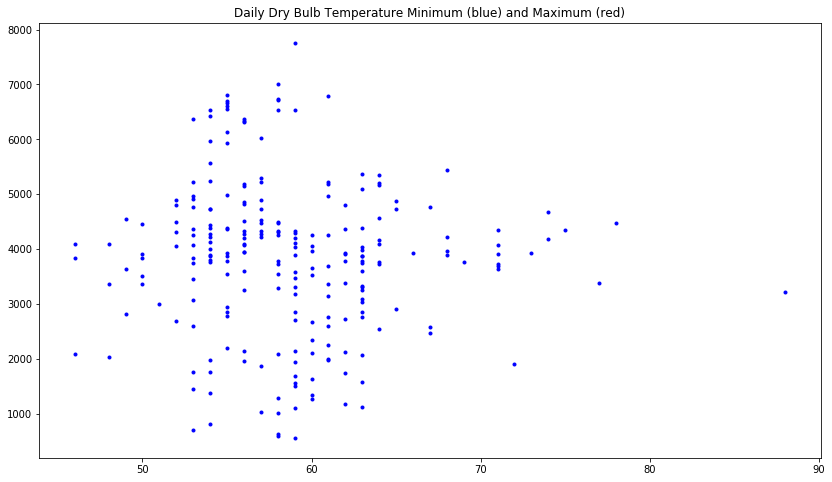

In [25]:
f=plt.figure(figsize=(14,8))
plt.plot(daily_bike_df.groupby('DATE')['DAILYAverageDryBulbTemp'].mean()[Weekday.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values],'b.')

plt.title('Daily Dry Bulb Temperature Minimum (blue) and Maximum (red)')

plt.show()


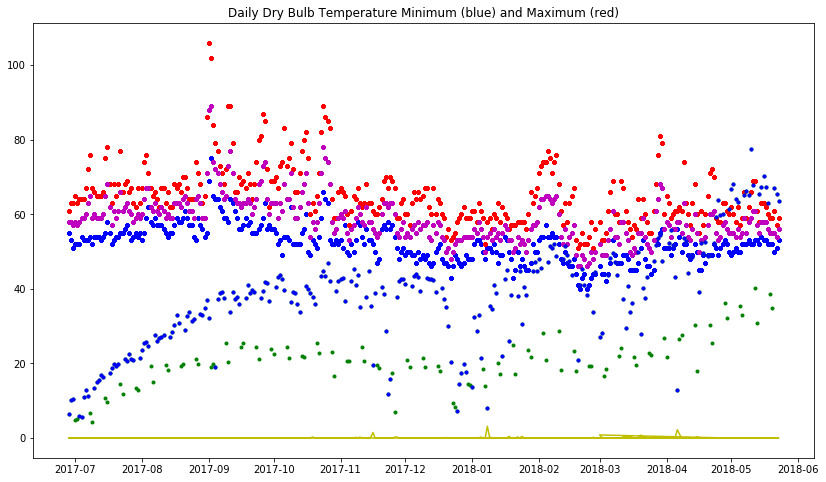

bike_id                                    int64
bike_share_for_all_trip                   object
duration_sec                               int64
end_station_id                           float64
end_station_latitude                     float64
end_station_longitude                    float64
end_station_name                          object
end_time                          datetime64[ns]
member_birth_year                        float64
member_gender                             object
start_station_id                         float64
start_station_latitude                   float64
start_station_longitude                  float64
start_station_name                        object
start_time                        datetime64[ns]
user_type                                 object
start_date                                object
DATE                                      object
DAILYMaximumDryBulbTemp                  float64
DAILYMinimumDryBulbTemp                  float64
DAILYAverageDryBulbT

In [26]:
f=plt.figure(figsize=(14,8))
plt.plot(daily_bike_df.DATE,daily_bike_df.DAILYMinimumDryBulbTemp,'b.')
plt.plot(daily_bike_df.DATE,daily_bike_df.DAILYMaximumDryBulbTemp,'r.')
plt.plot(daily_bike_df.DATE,daily_bike_df.DAILYAverageDryBulbTemp,'m.')
plt.plot(daily_bike_df.DATE,daily_bike_df.DAILYPrecip,'y')


#plt.plot(daily_bike_df.groupby('DATE').groups.keys(),daily_bike_df.groupby('DATE')['duration_sec'].mean()/100,'k.')
plt.plot(daily_bike_df.groupby('DATE').groups.keys(),daily_bike_df.groupby('DATE').duration_sec.count()/100,'g.')

dates=np.array(list(daily_bike_df.groupby('DATE').groups.keys()))
dates[Weekday.values]
plt.plot(dates[Weekday.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values]/100,'b.')



plt.title('Daily Dry Bulb Temperature Minimum (blue) and Maximum (red)')

plt.show()
print(daily_bike_df.dtypes)


Reset Index of bike_df

In [27]:
#bike_df=bike_df.sort_values(by=['start_time', 'end_time'])

In [28]:
#bike_df=bike_df.reset_index(drop=True)

In [29]:
# Join the bike and weather tables

In [30]:
#weather_df.dropna(axis=0, how='all', thresh=None, subset=['HOURLYPrecip'], inplace=False)
